### Используемые библиотеки

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

### EDA

In [27]:
df = pd.read_excel("asset-v1-SkillFactory+MIFIML-2sem+2025+type@asset+block@Данные_для_курсовои__Классическое_МО.xlsx")
display(df.head())

# удалим столбец Unnamed: 0
df = df.drop('Unnamed: 0', axis=1)

# выведем информацию о дубликатах и пропусках
display(df.info())
print(f'Общее количество пропусков {df.isna().sum().sum()}')
print(f'Число строк где есть хотя бы один пропуск {df.isna().any(axis=1).sum()}')
print(f'Колиество дубликатов {df.duplicated().sum()}')


,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB


None

Общее количество пропусков 36
Число строк где есть хотя бы один пропуск 3
Колиество дубликатов 32


In [28]:
# удалим строки с пропусками
df = df.dropna()
print(f'Общее количество пропусков {df.isna().sum().sum()}')

# удалим дубликаты
df = df.drop_duplicates()
print(f'Колиество дубликатов {df.duplicated().sum()}')

Общее количество пропусков 0
Колиество дубликатов 0


In [ ]:
# проверим данные каждого признака на средне кваратичное отклонение
print("Признаки со средне квадратичным отклонением равным нулю:")
for i in df.columns:
    if df[i].std() == 0:
        print(i)

# если среднеквадратичное отклонение равно 0, то следовательно и все значения в признаке равны
# как следствие признак не информативен для обучения
# удалим признаки имеющие среднеквадратичное отклонение 0

df = df.drop(columns=df.columns[df.std() == 0])

Признаки со средне квадратичным отклонением равным нулю:
NumRadicalElectrons
SMR_VSA8
SlogP_VSA9
fr_N_O
fr_SH
fr_azide
fr_barbitur
fr_benzodiazepine
fr_diazo
fr_dihydropyridine
fr_isocyan
fr_isothiocyan
fr_lactam
fr_nitroso
fr_phos_acid
fr_phos_ester
fr_prisulfonamd
fr_thiocyan


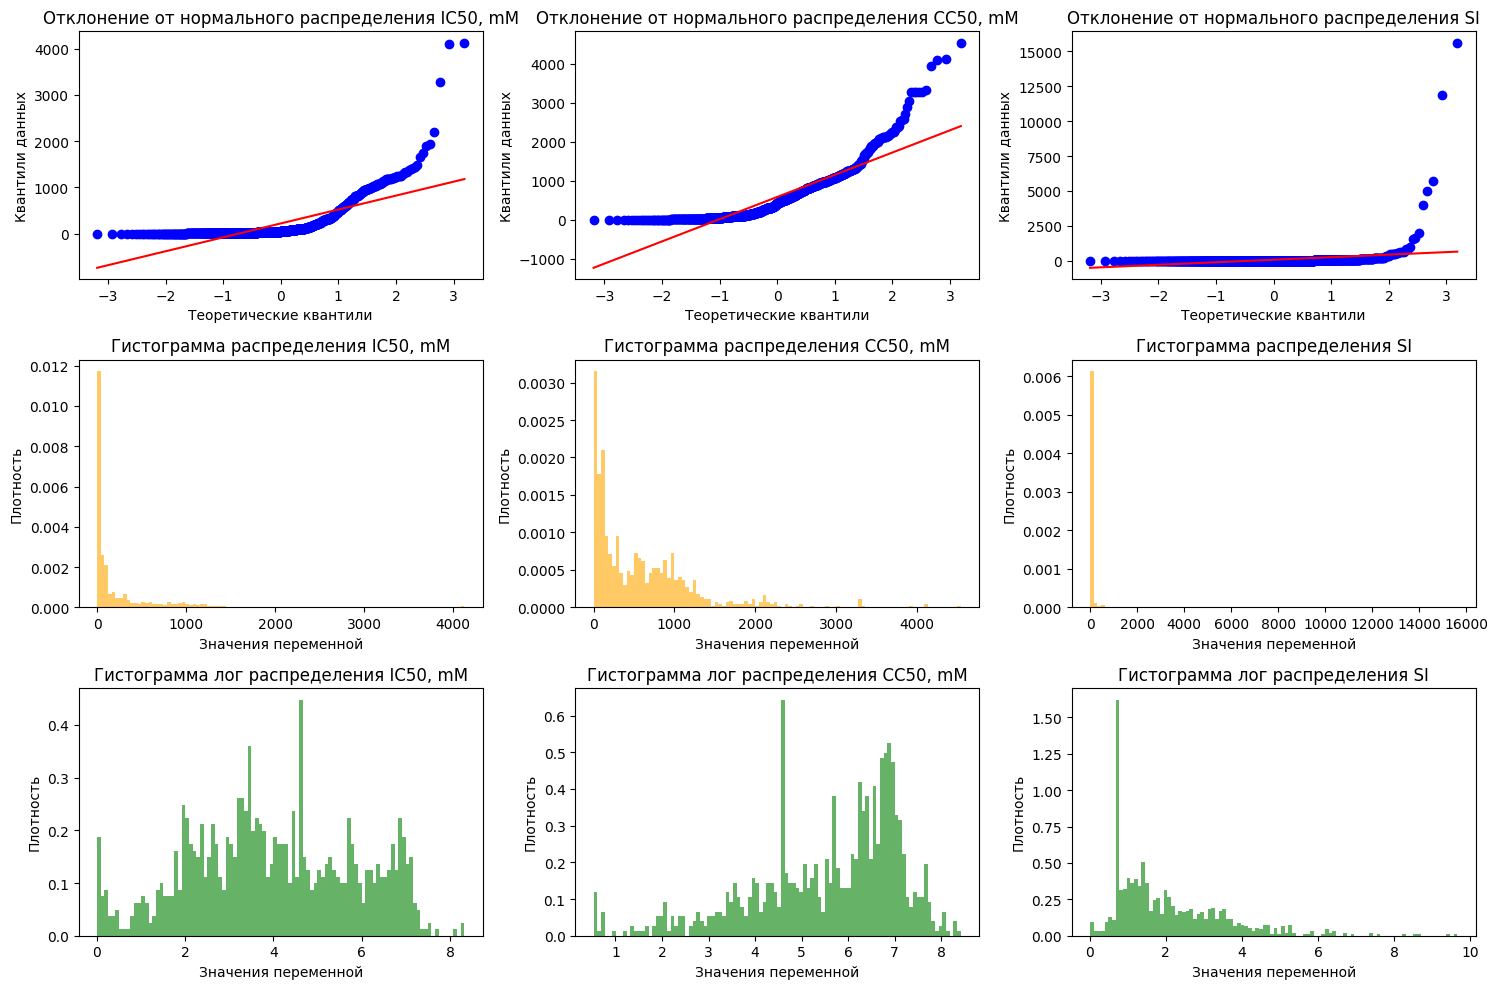

In [30]:
# проверим на нормальность распределения целевые переменные
# создаем график
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for i, col in enumerate(['IC50, mM', 'CC50, mM', 'SI']):
    # отклонение от нормального распределения
    stats.probplot(df[col], dist="norm", plot=axes[0][i])
    axes[0][i].set_title(f"Отклонение от нормального распределения {col}")
    axes[0][i].set_xlabel("Теоретические квантили")
    axes[0][i].set_ylabel("Квантили данных")

    # гистограммы
    axes[1][i].hist(df[col], bins=100, density=True, alpha=0.6, color='orange')
    axes[1][i].set_title(f'Гистограмма распределения {col}')
    axes[1][i].set_xlabel('Значения переменной')
    axes[1][i].set_ylabel('Плотность')

    # гистограммы логарифмированных данных
    axes[2][i].hist(np.log(df[col] + 1), bins=100, density=True, alpha=0.6, color='green')
    axes[2][i].set_title(f'Гистограмма лог распределения {col}')
    axes[2][i].set_xlabel('Значения переменной')
    axes[2][i].set_ylabel('Плотность')

# выводим график
plt.tight_layout()
plt.show()


# прологарифмируем значения целевых переменных
for col in ['IC50, mM', 'CC50, mM', 'SI']:
    df[col] = np.log(df[col] + 1)


In [31]:
# разделим данные на целевые переменные и признаки
df_y = df[['IC50, mM', 'CC50, mM', 'SI']]
df_x = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])


In [32]:
# проверим признаки на наличия выбросов с помощью процентиля, который представляет из себя 99% квантиль
# то есть будем заменять те значения, которые превышают значение 99% данных по каждому из признаков

# 99 процентиль для каждого столбца имеющий тип значения float
df_x_float = df_x.select_dtypes(include=[float])
percentil = df_x_float.quantile(0.99)
df_x_float = df_x_float[percentil.index].clip(upper=percentil, axis=1)

# 99 процентиль для каждого столбца имеющий тип значения int
df_x_int = df_x.select_dtypes(include=[int])
percentil = df_x_int.quantile(0.99).astype(int)
df_x_int = df_x_int[percentil.index].clip(upper=percentil, axis=1)

# собираем датасет обратно
df_x = pd.concat([df_x_float, df_x_int], axis=1)
display(df_x.head())

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,MaxPartialCharge,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,0.038844,...,0,0,0,0,0,0,0,0,3,0
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,0.012887,...,0,0,0,0,0,0,0,0,3,0
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,0.094802,...,2,0,0,0,0,0,0,0,3,0
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,0.038844,...,0,0,0,0,0,0,0,0,4,0
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,0.062897,...,0,0,0,0,0,0,0,0,0,0


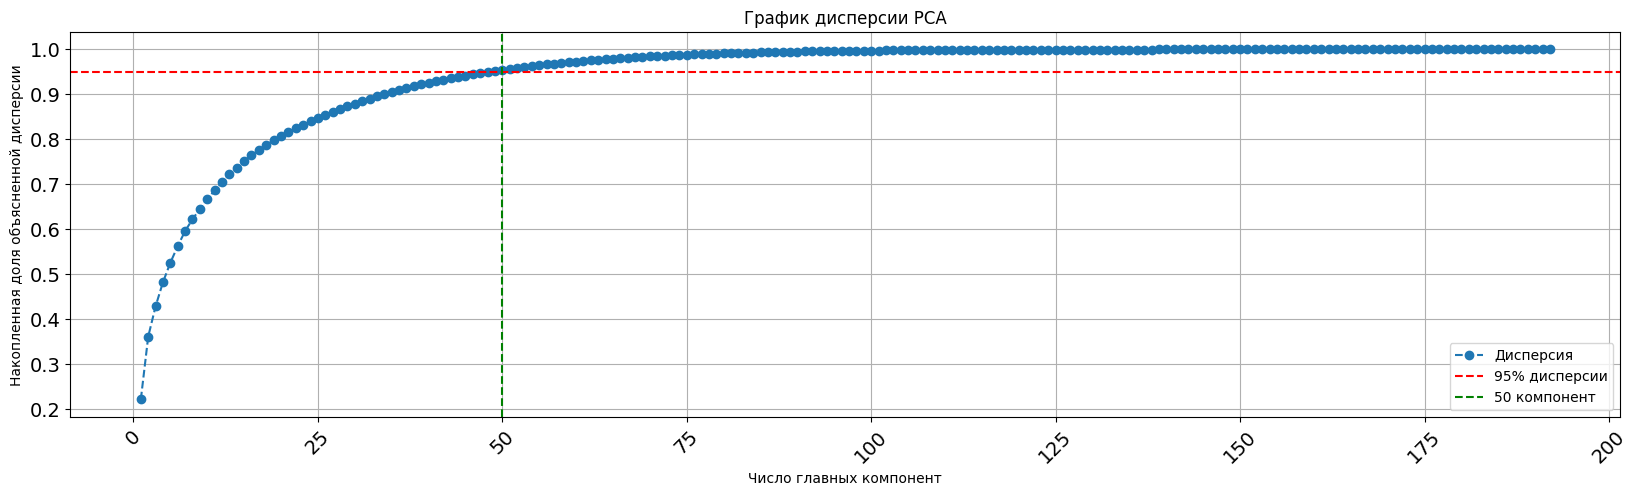

In [33]:
# проверим на количество компанент необходимых для сохранения 95% данных
# стандартизируем данные
scaler = StandardScaler()
scaled_df_x = pd.DataFrame(scaler.fit_transform(df_x), columns=df_x.columns)
# создадим объект метода главных компанент
pca = PCA()
pca.fit(scaled_df_x)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# создаем график
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label="Дисперсия")

# добавляем горизонтальную линию на уровне 0.95
plt.axhline(y=0.95, color='r', linestyle='--', label="95% дисперсии")

# добавляем вертикальную линию на 50 компонентах
plt.axvline(x=50, color='g', linestyle='--', label="50 компонент")

# подписываем оси и название графика
plt.xlabel('Число главных компонент')
plt.ylabel('Накопленная доля объясненной дисперсии')
plt.title('График дисперсии PCA')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()

# отобразим график
plt.show()

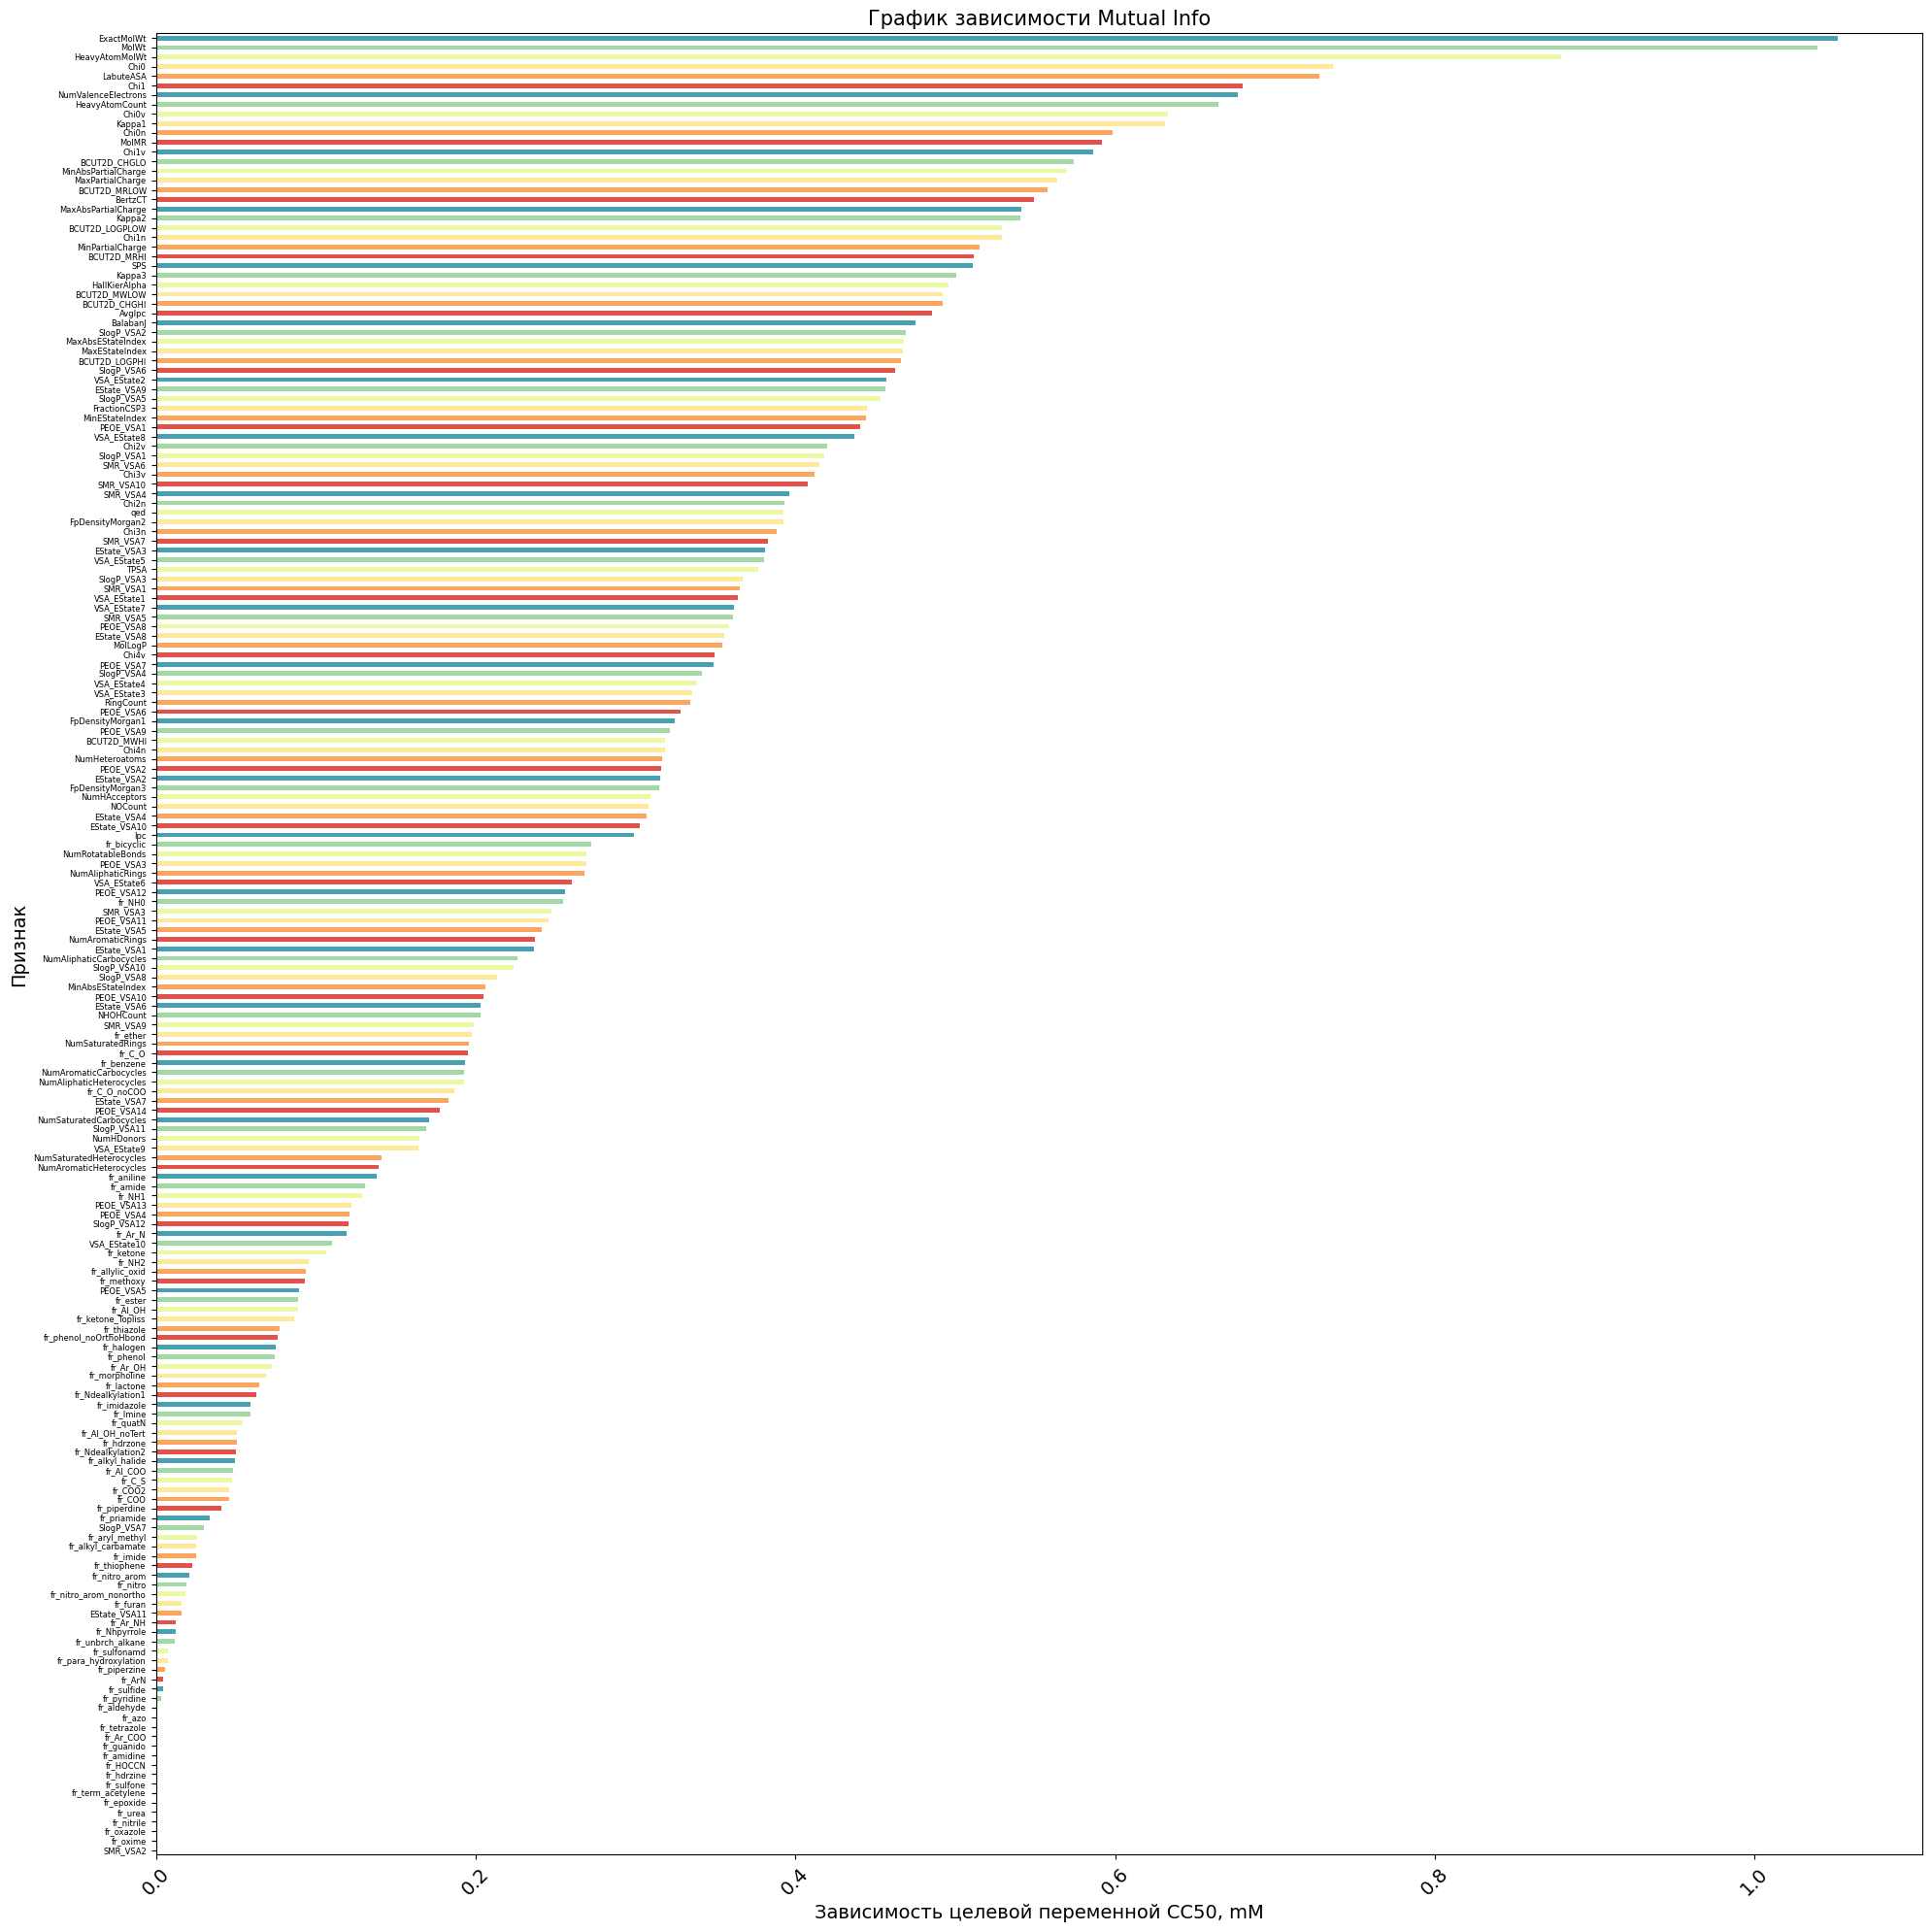

In [34]:
# проверим зависимость CC50, mM от признаков с помощью Mutual Info
importances = mutual_info_regression(scaled_df_x, df_y['CC50, mM'])
feature_importances = pd.Series(importances, scaled_df_x.columns)
feature_importances = feature_importances.sort_values()

# создадим график
plt.figure(figsize=(20,20))
feature_importances.plot(kind='barh', color=sns.color_palette("Spectral"))

# подпишем оси
plt.xlabel('Зависимость целевой переменной CC50, mM', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.title('График зависимости Mutual Info', fontsize=15)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=6)

# отобразим график
plt.tight_layout()
plt.show()


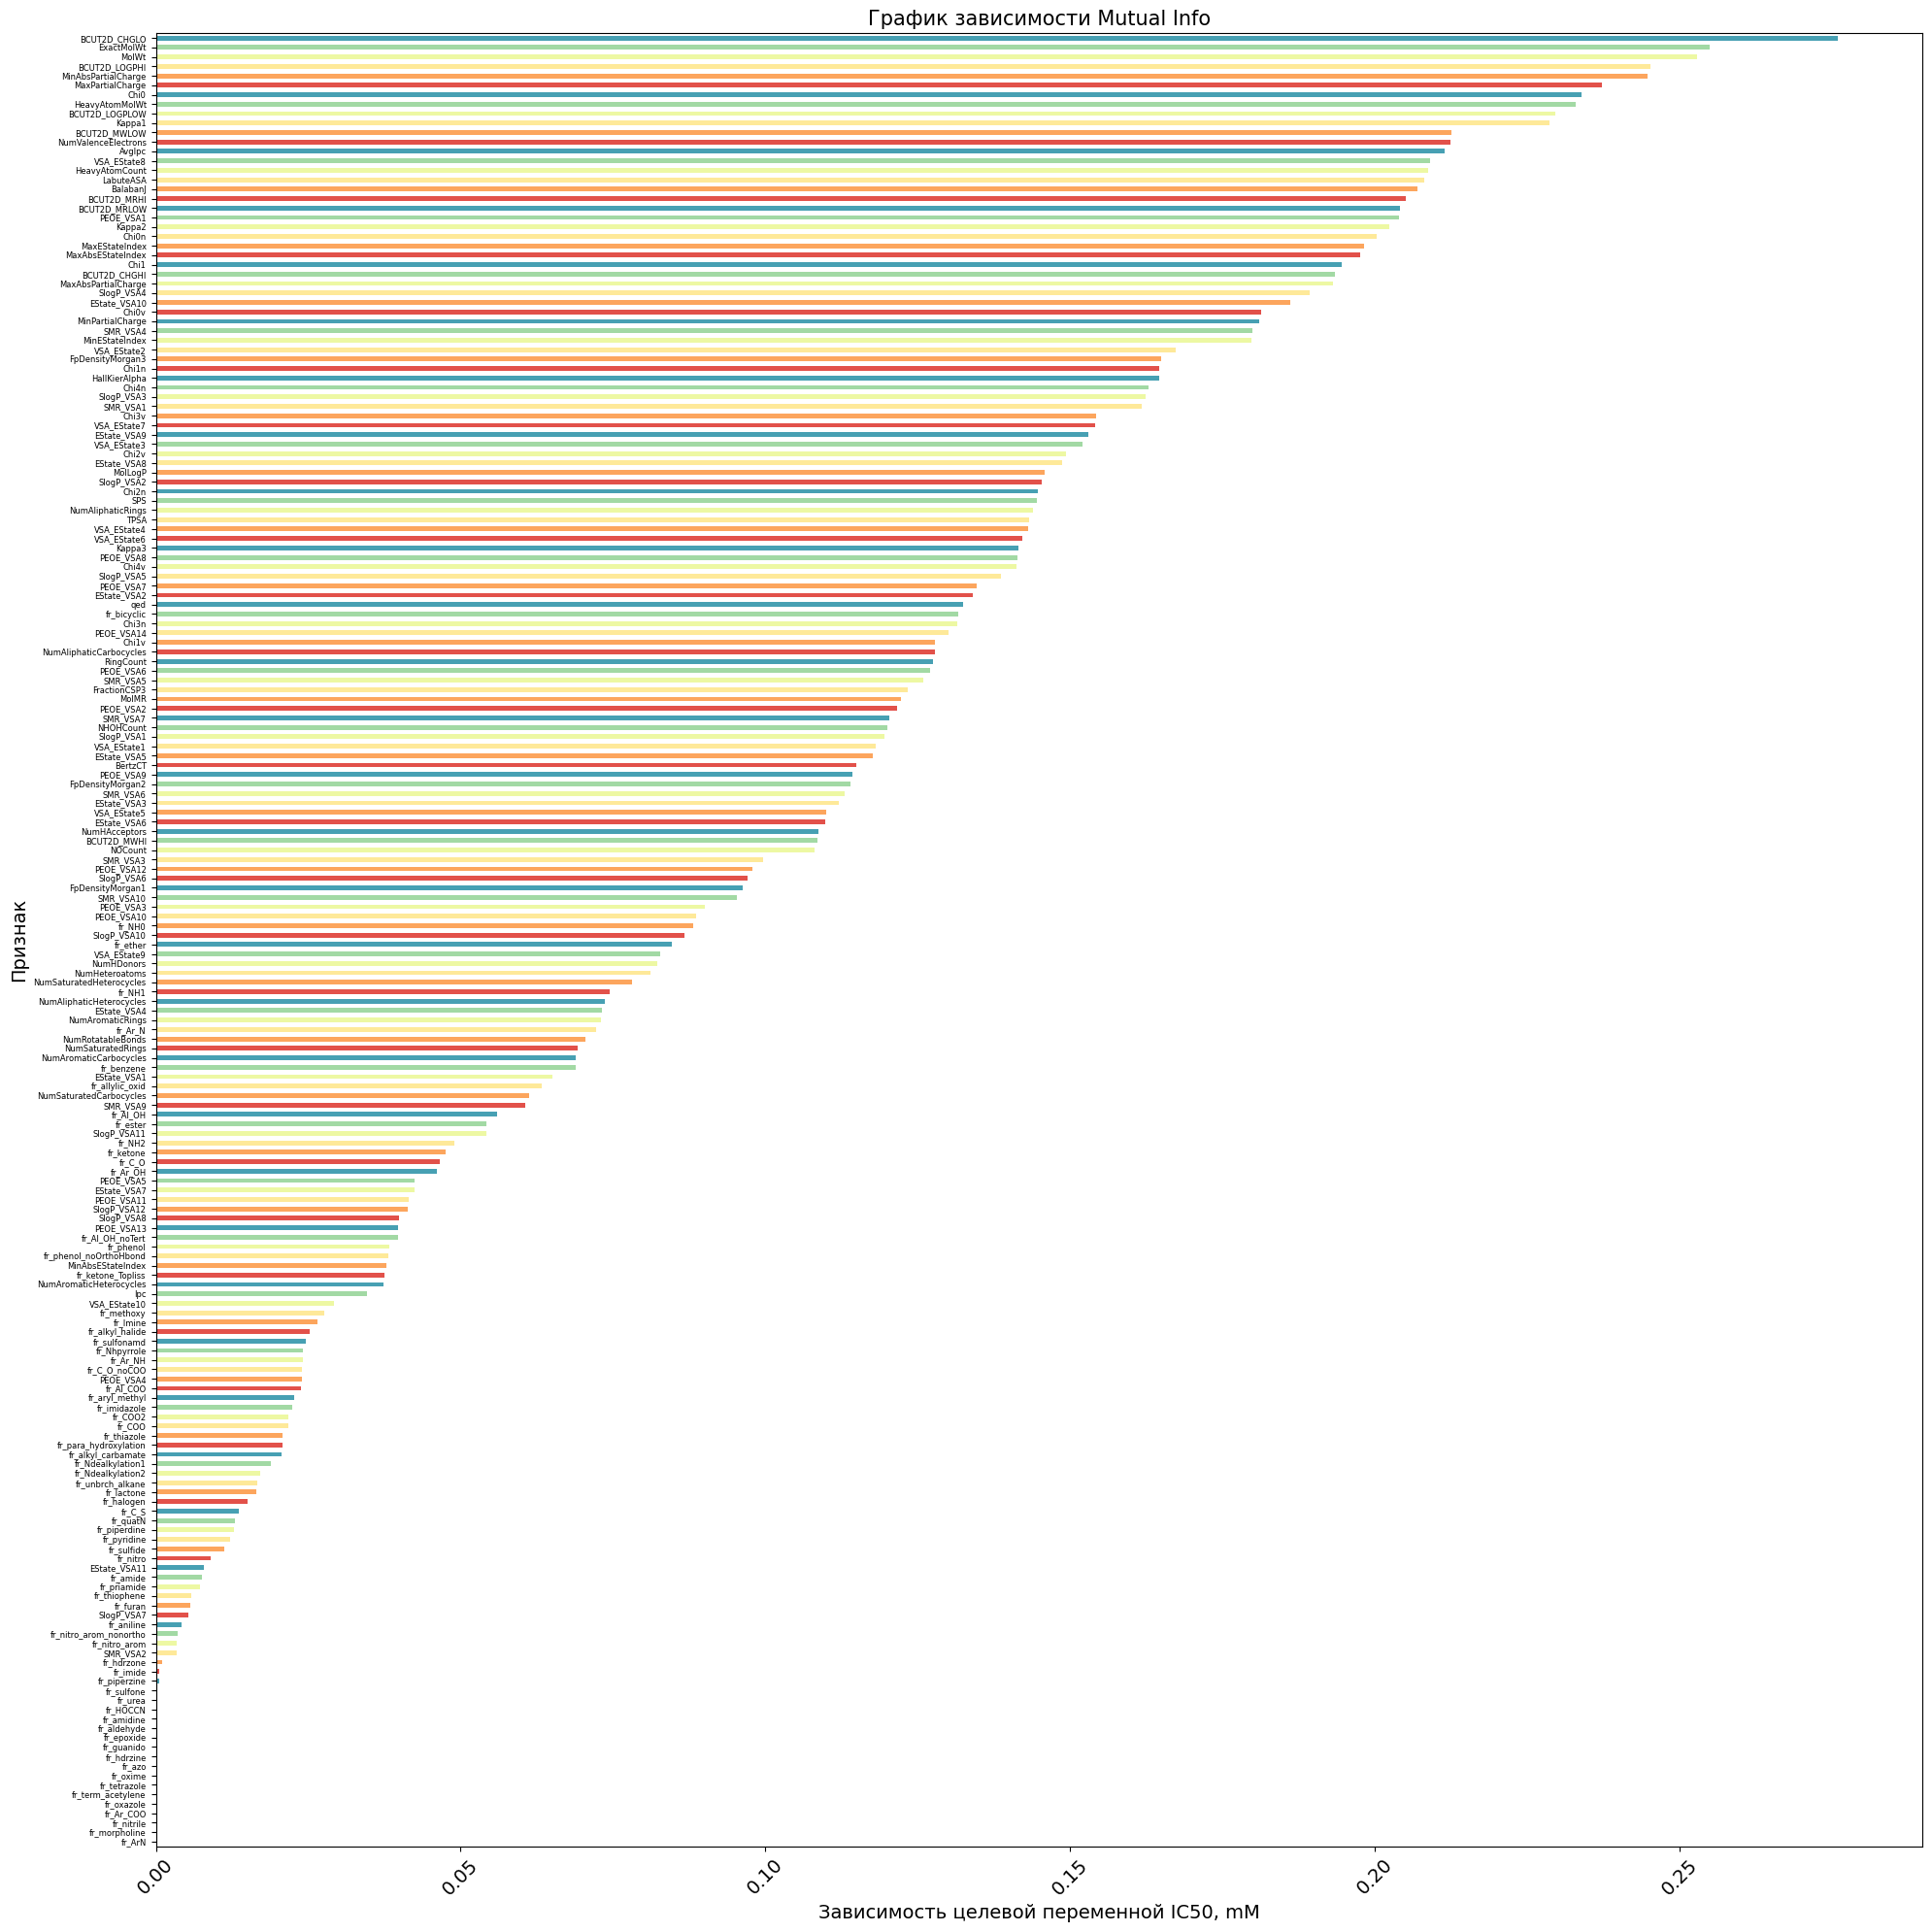

In [35]:
# проверим зависимость IC50, mM от признаков с помощью Mutual Info
importances = mutual_info_regression(scaled_df_x, df_y['IC50, mM'])
feature_importances = pd.Series(importances, scaled_df_x.columns)
feature_importances = feature_importances.sort_values()

# создадим график
plt.figure(figsize=(20,20))
feature_importances.plot(kind='barh', color=sns.color_palette("Spectral"))

# подпишем оси
plt.xlabel('Зависимость целевой переменной IC50, mM', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.title('График зависимости Mutual Info', fontsize=15)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=6)

# отобразим график
plt.tight_layout()
plt.show()

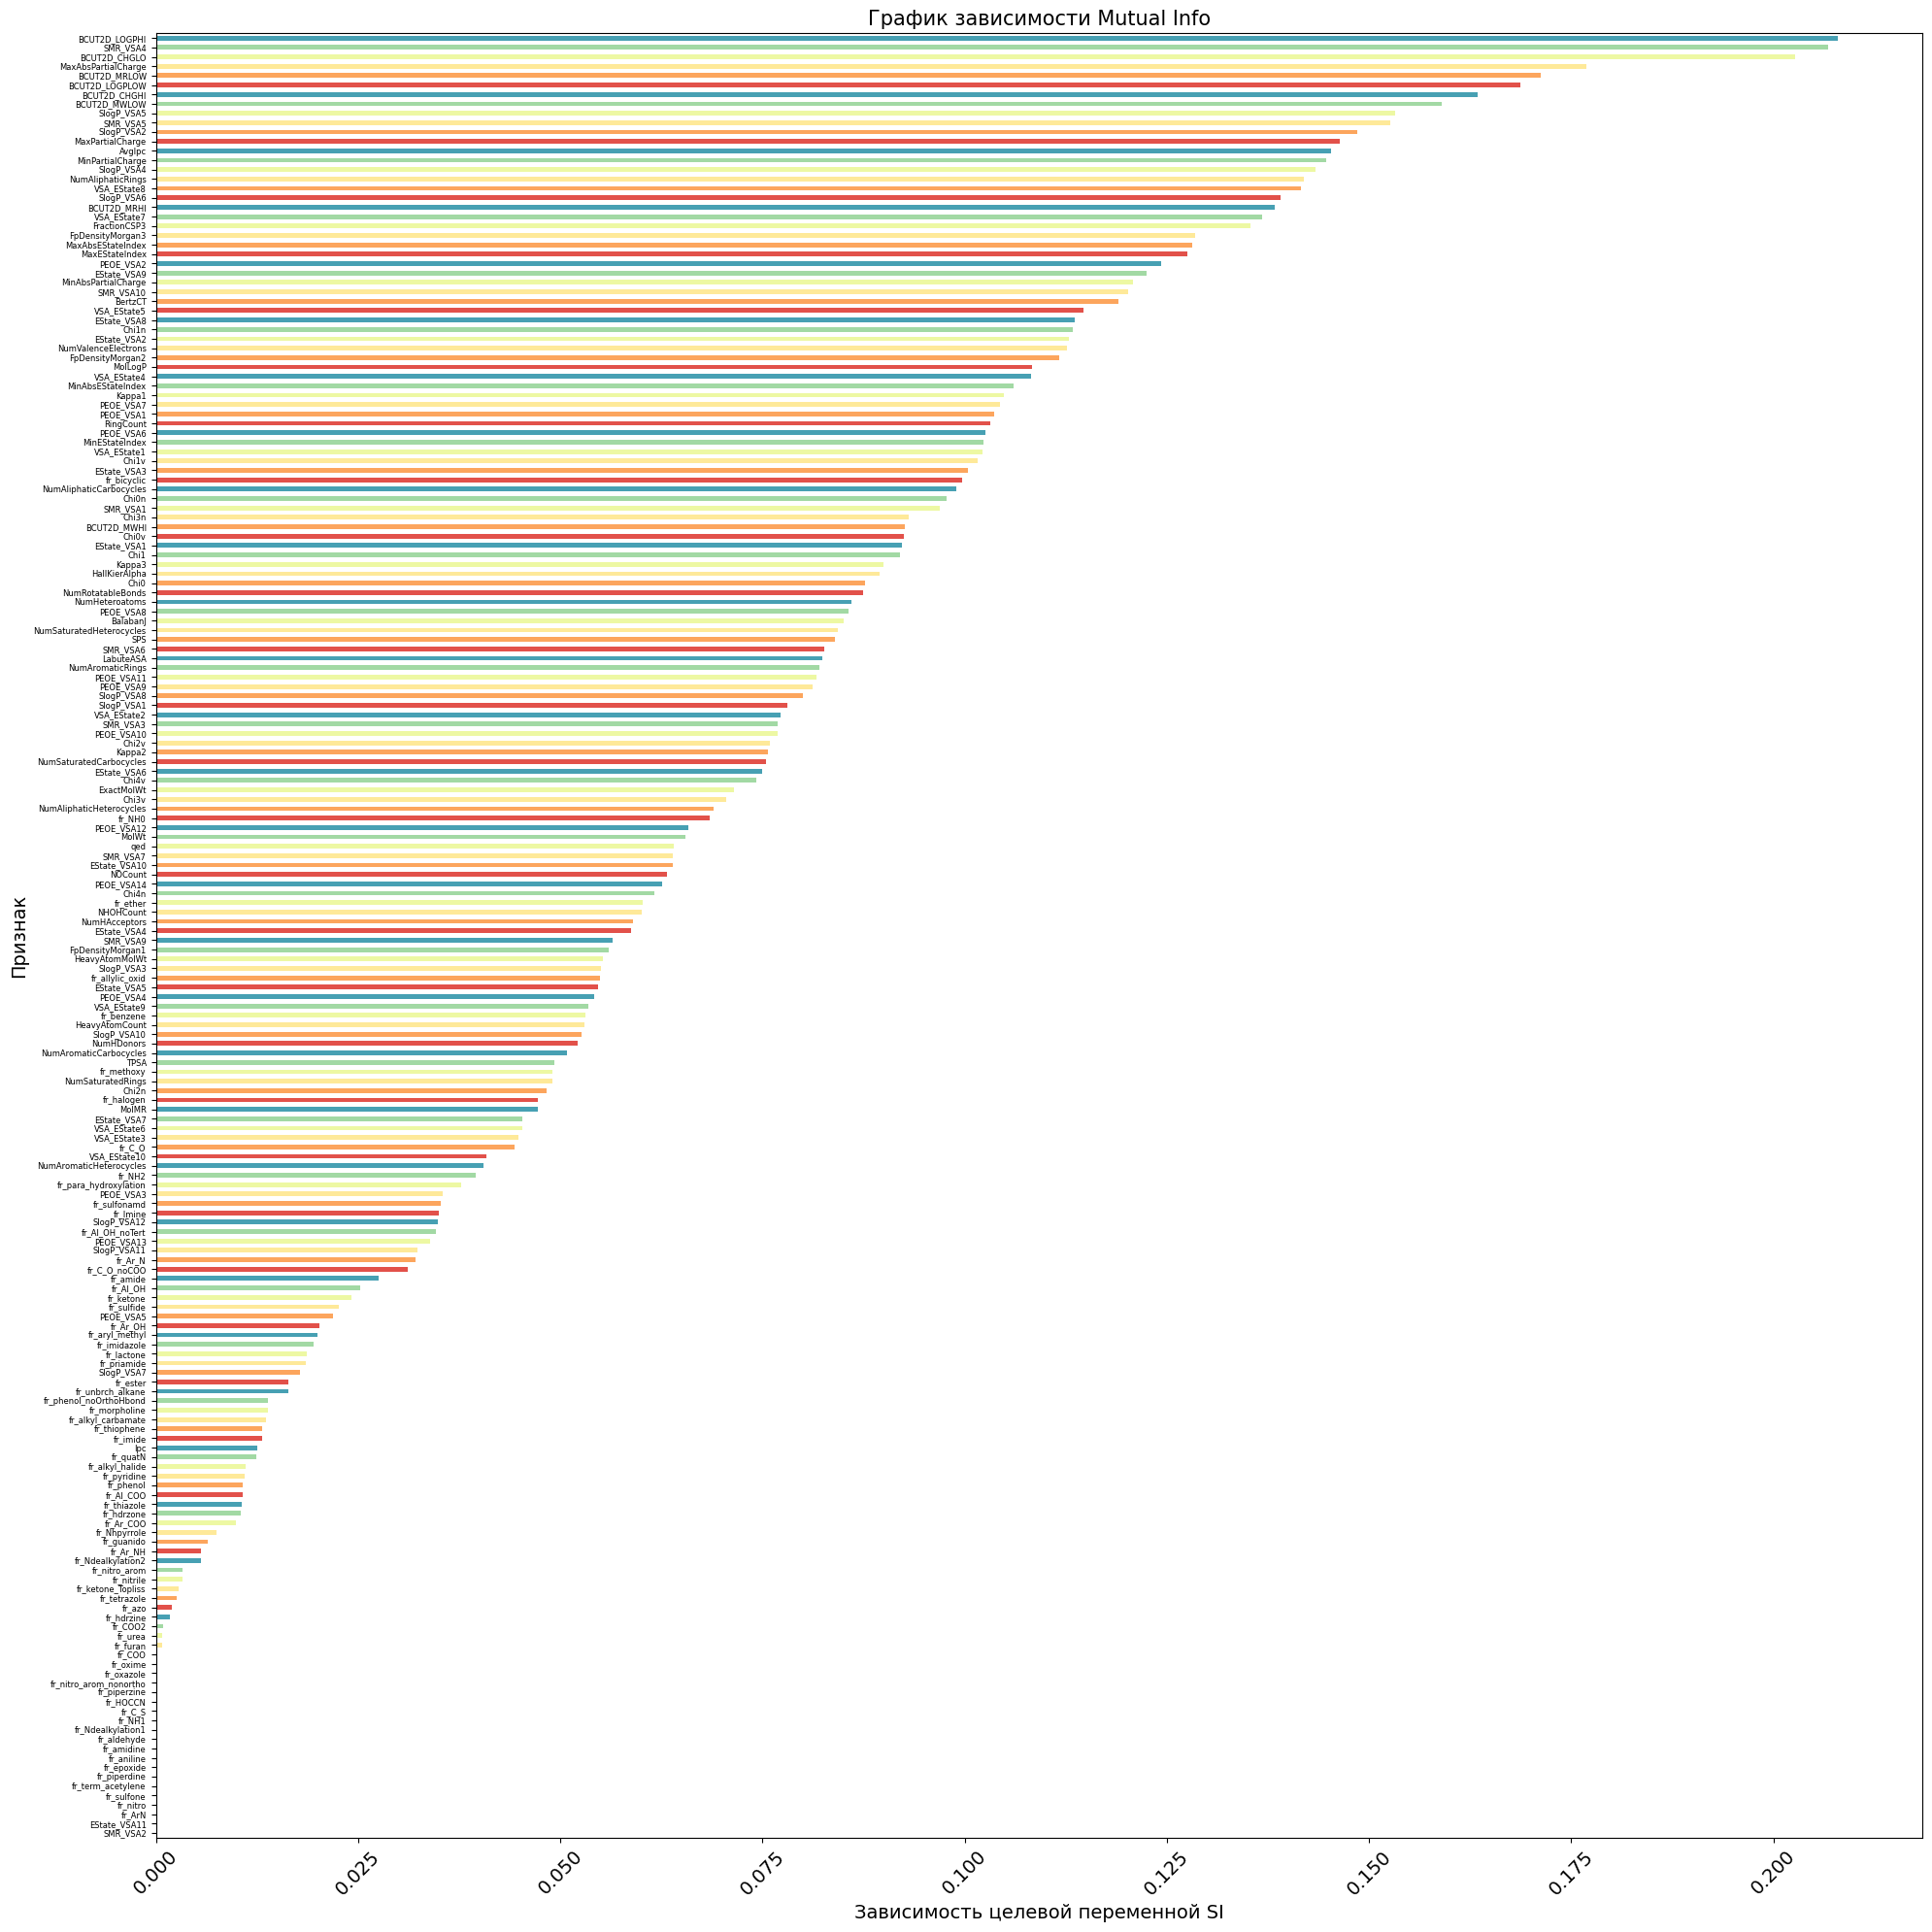

In [36]:
# проверим зависимость SI от признаков с помощью Mutual Info
importances = mutual_info_regression(scaled_df_x, df_y['SI'])
feature_importances = pd.Series(importances, scaled_df_x.columns)
feature_importances = feature_importances.sort_values()

# создадим график
plt.figure(figsize=(20,20))
feature_importances.plot(kind='barh', color=sns.color_palette("Spectral"))

# подпишем оси
plt.xlabel('Зависимость целевой переменной SI', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.title('График зависимости Mutual Info', fontsize=15)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=6)

# отобразим график
plt.tight_layout()
plt.show()

In [37]:
# сохраянем в новый файл для дальнейшей работы
df = df_x = pd.concat([df_x, df_y], axis=1)
df.to_csv('data.csv', index=False, encoding='utf-8')

#### Вывод
1) Удалён неинформативный признак 'Unnamed: 0'
2) Удалены 3 строки, в которых содержался хотя бы один пропуск
3) Удалено 32 дубликата
4) Удалены признаки, имеющие среднеквадратичное отклонение равное 0. Так как если среднеквадратичное отклонение равно 0, то, следовательно, и все значения в признаке одинаковы
5) Прологарифмированы целевые переменные, так как графики показали отсутствие нормального распределения
6) Значения данных каждого из признаков превышающие значение 99% квантиля данного признака, были заменены на значение перцентиля, то есть на значение 99% квантиля.
7) При помощи метода главных компонент была оценена дисперсия для сохранения 95% данных. Значение составило 50 компонент
8) При помощи метода Mutual Info была проверена зависимость каждой из трех целевых переменных от признаков

Далее для выполнение поставленной задачи требуется подходить индивидуально к каждому пункту - делить, подготавливать, оценивать полученный результат и т.д.

Так как значение метрики SI, рассчитываются на основе метрик IC50 и СС50, то при обучение следует воздержаться от использования метрики SI в качестве признака для целевых переменных IC50 и СС50.